<a href="https://colab.research.google.com/github/Ashis-Palai/Chroma_Db/blob/main/GenAI_Chroma_Db.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain pypdf chromadb sentence-transformers langchain-community langchain_google_genai

In [ ]:
def word_wrap(string, n_chars=72):
    # Wrap a string at the next space after n_chars
    if len(string) < n_chars:
        return string
    else:
        return string[:n_chars].rsplit(' ', 1)[0] + '\n' + word_wrap(string[len(string[:n_chars].rsplit(' ', 1)[0])+1:], n_chars)


In [ ]:
from langchain.document_loaders import PyPDFLoader

reader = PyPDFLoader('/content/microsoft_annual_report_2022.pdf').load()


In [ ]:
text = [page.page_content.strip() for page in reader]
text = [t for t in text if t]


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter , SentenceTransformersTokenTextSplitter

In [ ]:
char_splitter = RecursiveCharacterTextSplitter(
                           separators= ['\n\n','\n','.',' ',''],
                           chunk_size = 1000,
                           chunk_overlap = 0   )

char_split_text  =  char_splitter.split_text('\n\n'.join(text))

In [ ]:
print(word_wrap(char_split_text[10]))

In [ ]:
sentence_token = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)
token_split_text = []
for text in char_split_text:
  token_split_text += sentence_token.split_text(text)


In [ ]:
len(token_split_text)

349

In [ ]:
import chromadb
import langchain
import langchain_community
from langchain_community.embeddings import SentenceTransformerEmbeddings

In [ ]:
emb = SentenceTransformerEmbeddings()
res = emb.embed_query(text[0])

In [ ]:
res[0]

-0.023618357256054878

In [ ]:
from chromadb.utils.embedding_functions import GoogleGenerativeAiEmbeddingFunction
emb = GoogleGenerativeAiEmbeddingFunction(api_key = api_key)

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_text[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[0.04256267845630646, 0.033211849629879, 0.03034009225666523, -0.034866586327552795, 0.06841650605201721, -0.08090908825397491, -0.015474384650588036, -0.001450937008485198, -0.016744472086429596, 0.06770772486925125, -0.05054135248064995, -0.04919537156820297, 0.05139991268515587, 0.09192730486392975, -0.07177839428186417, 0.039519693702459335, -0.012833530083298683, -0.02494746446609497, -0.04622865840792656, -0.02435753121972084, 0.03394966572523117, 0.02550245262682438, 0.027317119762301445, -0.0041262200102210045, -0.03633834794163704, 0.0036908735055476427, -0.027430471032857895, 0.004796730354428291, -0.028896236792206764, -0.018870729953050613, 0.03666628524661064, 0.02569585107266903, 0.03131284937262535, -0.0639343410730362, 0.05394405871629715, 0.08225349336862564, -0.04175683856010437, -0.00699579669162631, -0.02348603680729866, -0.030747927725315094, -0.0029792017303407192, -0.07790938764810562, 0.009353099390864372, 0.003162842011079192, -0.022257033735513687, -0.0182946

In [ ]:
chroma_client = chromadb.Client()

In [ ]:
chroma_collection = chroma_client.create_collection('microsoft_annual_report_2022',embedding_function=embedding_function)

ids = [str(id)for id in range(len(token_split_text))]

chroma_collection.add(ids=ids,documents=token_split_text)

In [ ]:
chroma_collection.count()

349

In [ ]:
query = 'what was the total revenue?'

results =  chroma_collection.query(query_texts = [query],n_results=3)
results

{'ids': [['321', '293', '331']],
 'distances': [[0.791434645652771, 0.8486630320549011, 0.9124016761779785]],
 'metadatas': [[None, None, None]],
 'embeddings': None,
 'documents': [['revenue, classified by significant product and service offerings, was as follows : ( in millions ) year ended june 30, 2022 2021 2020 server products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22, 488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8, 077 search and news advertising 11, 591 9, 267 8, 524 enterprise services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291 4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast certain previously reported amounts in the table above to conform to the way we internally manage and monitor our business.',
   '74 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2022 2021 productivity and busin

In [ ]:
results['documents'][0]

['revenue, classified by significant product and service offerings, was as follows : ( in millions ) year ended june 30, 2022 2021 2020 server products and cloud services $ 67, 321 $ 52, 589 $ 41, 379 office products and cloud services 44, 862 39, 872 35, 316 windows 24, 761 22, 488 21, 510 gaming 16, 230 15, 370 11, 575 linkedin 13, 816 10, 289 8, 077 search and news advertising 11, 591 9, 267 8, 524 enterprise services 7, 407 6, 943 6, 409 devices 6, 991 6, 791 6, 457 other 5, 291 4, 479 3, 768 total $ 198, 270 $ 168, 088 $ 143, 015 we have recast certain previously reported amounts in the table above to conform to the way we internally manage and monitor our business.',
 '74 note 13 — unearned revenue unearned revenue by segment was as follows : ( in millions ) june 30, 2022 2021 productivity and business processes $ 24, 558 $ 22, 120 intelligent cloud 19, 371 17, 710 more personal computing 4, 479 4, 311 total $ 48, 408 $ 44, 141 changes in unearned revenue were as follows : ( in m

In [ ]:
for i in range(len(results['ids'][0])):
  print(f"{results['ids'][0][i]}, \n{results['distances'][0][i]},\n{word_wrap(results['documents'][0][i])}\n\n")

In [ ]:
# import os
# import openai
# from openai import OpenAI

# from dotenv import load_dotenv, find_dotenv
# _ = load_dotenv(find_dotenv()) # read local .env file
# openai.api_key = os.environ['OPENAI_API_KEY']

# openai_client = OpenAI()

# def rag(query, retrieved_documents, model="gpt-3.5-turbo"):
#     information = "\n\n".join(retrieved_documents)

#     messages = [
#         {
#             "role": "system",
#             "content": "You are a helpful expert financial research assistant. Your users are asking questions about information contained in an annual report."
#             "You will be shown the user's question, and the relevant information from the annual report. Answer the user's question using only this information."
#         },
#         {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
#     ]

#     response = openai_client.chat.completions.create(
#         model=model,
#         messages=messages,
#     )
#     content = response.choices[0].message.content
#     return content

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from google.colab import userdata
api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
def your_buddy(query):

  results = chroma_collection.query(query_texts=query,n_results = 10)
  context = results['documents'][0]


  prompt = '''You are an expert financial research assistant, you will be asked question, the question is:\n{query}\n\n
  you utilise your expertise along with the context given to you, the context is: \n{context}\n\n answer is :'''

  prompt_template = ChatPromptTemplate.from_template(template=prompt)
  prompt_llm = prompt_template.format_messages(query=query,context = context)
  llm = ChatGoogleGenerativeAI(google_api_key=api_key,model = 'gemini-pro')
  response =  llm.invoke(prompt_llm)

  return response.content



In [ ]:
your_buddy(query)

'198,270'

## **changing the embeddings:**

In [ ]:
chroma_client.list_collections()

[Collection(name=new_collection),
 Collection(name=microsoft_annual_report_2022)]

In [ ]:
chroma_client.delete_collection('new_collection')

In [ ]:
chroma_client = chromadb.Client()
new_collection = chroma_client.create_collection('new_collection',embedding_function= emb)
ids =  [str(i) for i in range(len(token_split_text))]
new_collection.add(ids= ids,documents = token_split_text)

In [ ]:
def your_buddy(query):

  results = new_collection.query(query_texts=query,n_results = 10)
  context = results['documents'][0]


  prompt = '''You are an expert financial research assistant, you will be asked question, the question is:\n{query}\n\n
  you utilise your expertise along with the context given to you, the context is: \n{context}\n\n answer is :'''

  prompt_template = ChatPromptTemplate.from_template(template=prompt)
  prompt_llm = prompt_template.format_messages(query=query,context = context)
  llm = ChatGoogleGenerativeAI(google_api_key=api_key,model = 'gemini-pro')
  response =  llm.invoke(prompt_llm)

  return response.content



In [ ]:
your_buddy(query)

'$198,270'

In [ ]:
your_buddy("what is revenue increased Fiscal Year 2022 Compared with Fiscal Year 2021?")

'18 %'

In [ ]:
your_buddy("What is the strategy around artificial intelligence (AI) ?")

'In the next phase of innovation, artificial intelligence ( " AI " ) capabilities are rapidly advancing, fueled by data and knowledge of the world.'

In [ ]:
your_buddy("What has been the investment in research and development?")


'The investment in research and development has been significant, with a $3.8 billion increase in 2022 compared to 2021. This 18% increase was driven by investments in cloud engineering, gaming, and LinkedIn. Overall, research and development expenses totaled $24,512 million in 2022, representing 12% of revenue.'

In [ ]:
your_buddy("What has Michael Jordan done for us lately?")


'The provided context does not have information about what Michael Jordan has done lately, so I cannot answer this question.'

### **Pitfalls of retrieval - when simple vector search fails**

In [ ]:
!pip uninstall umap
!pip install umap-learn

In [ ]:
import umap.umap_ as umap
import numpy as np
from tqdm.auto import tqdm

In [ ]:
embeddings = new_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    # umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [ ]:
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

  0%|          | 0/349 [00:00<?, ?it/s]

(2.3048312783241274, 12.81091068983078, 1.4890301167964934, 8.723035937547683)

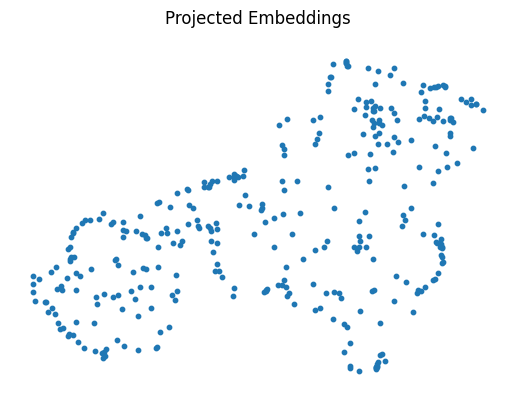

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

In [ ]:
query = "What is the total revenue?"

results = new_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    print(word_wrap(document))
    print('')

total $ 69, 641 $ ( 2, 368 ) $ 3, 138 $ ( 446 ) $ 72, 779 $ ( 2, 814 )

income before tax. other reconciling items, net

##9 sales of investments 28, 443 14, 008 17, 721 other, net ( 2, 825 )
( 922 ) ( 1, 241 )

of each of these audits is not expected to be material to our
consolidated financial statements.

total liabilities and stockholders ’ equity $ 364, 840 $ 333, 779 refer
to accompanying notes.



In [ ]:
query_embedding = emb([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(2.3048312783241274, 12.81091068983078, 1.4890301167964934, 8.723035937547683)

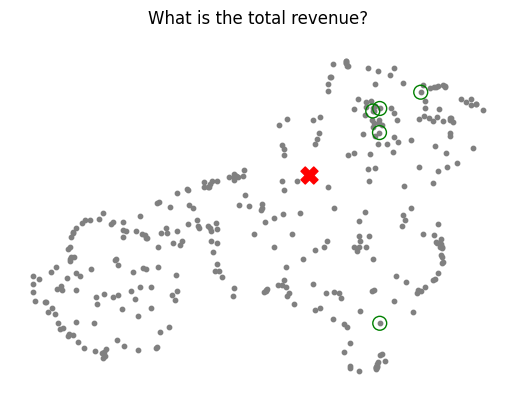

In [ ]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [ ]:
def  plot_query_emb(query):
  results = new_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
  retrieved_documents = results['documents'][0]
  query_embedding = emb([query])[0]
  retrieved_embeddings = results['embeddings'][0]
  projected_query_embedding = project_embeddings([query_embedding], umap_transform)
  projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)
  plt.figure()
  plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
  plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
  plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'{query}')
  plt.axis('off')



  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

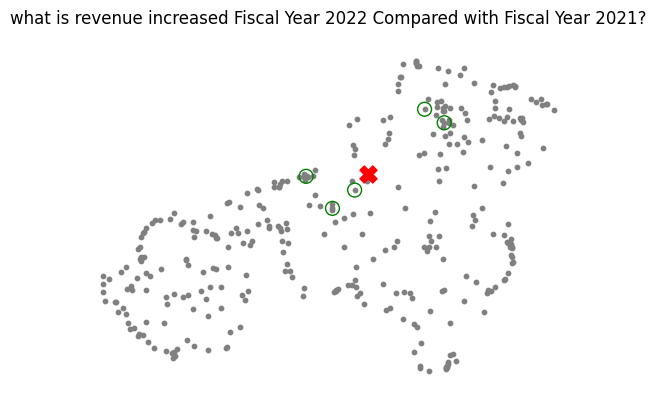

In [ ]:
plot_query_emb('what is revenue increased Fiscal Year 2022 Compared with Fiscal Year 2021?')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

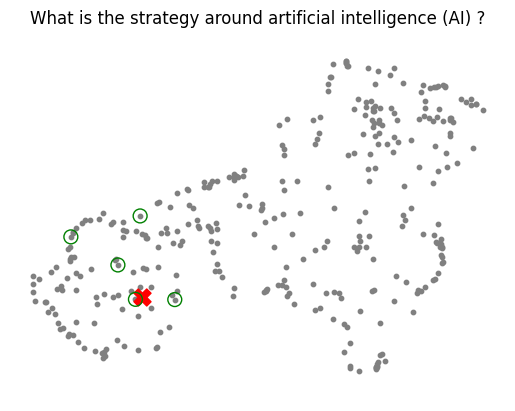

In [ ]:
plot_query_emb('What is the strategy around artificial intelligence (AI) ?')


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

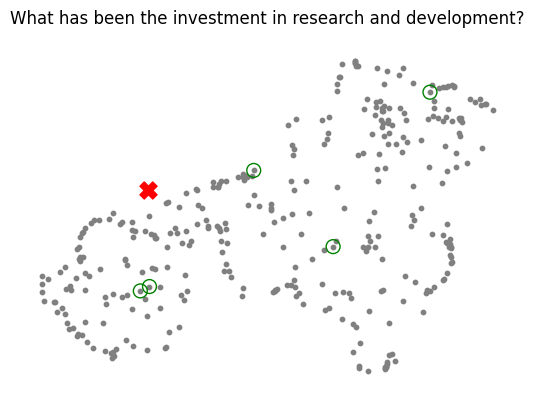

In [ ]:
plot_query_emb('What has been the investment in research and development?')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

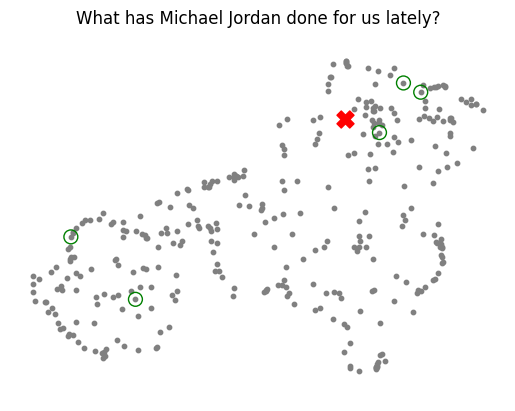

In [ ]:
plot_query_emb('What has Michael Jordan done for us lately?')

## **Advanced Query Expansion:**

### **Expansion with generated answers¶**
https://arxiv.org/abs/2305.03653


### **query --> LLM --> (Generic Answer by LLM + Retrived Doc from VDB) --> LLM --> Final Answer**

In [ ]:
# def augment_query_generated(query, model="gpt-3.5-turbo"):
#     messages = [
#         {
#             "role": "system",
#             "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
#         },
#         {"role": "user", "content": query}
#     ]

#     response = openai_client.chat.completions.create(
#         model=model,
#         messages=messages,
#     )
#     content = response.choices[0].message.content
#     return content

In [ ]:
########## Gemini By Author Ashis#############

def augment_query_generated(query):
  llm = ChatGoogleGenerativeAI(google_api_key=api_key, model = 'gemini-pro')
  prompt = f"You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report.\n\n questions is {query}\n\n answer is : "
  response = llm.invoke(prompt)
  return response.content

In [ ]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

Was there significant turnover in the executive team? **Executive Team
Turnover**

In the past year, there has been significant turnover in
the Company's executive team. Three members of the team have departed,
including the Chief Executive Officer (CEO), the Chief Financial
Officer (CFO), and the Chief Operating Officer (COO). The departures
were due to a variety of factors, including retirement, resignation,
and termination.

The Company has taken steps to fill the vacant
positions. A new CEO and CFO have been appointed, and a search is
underway for a new COO. The Company is confident that the new executive
team will be able to provide the leadership and direction necessary to
achieve the Company's strategic goals.

The turnover in the executive
team has had a number of impacts on the Company. In the short term, it
has led to some disruption and uncertainty. However, the Company is
confident that the long-term impact will be positive. The new executive
team has a wealth of experience

In [ ]:
def  plot_query_emb_new(query):
  results = new_collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])
  retrieved_documents = results['documents'][0]
  retrieved_embeddings = results['embeddings'][0]
  original_query_embedding = emb([query])
  augmented_query_embedding = emb([joint_query])


  projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
  projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
  projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)


  plt.figure()
  plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
  plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
  plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
  plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')



  plt.gca().set_aspect('equal', 'datalim')
  plt.title(f'{query}')
  plt.axis('off')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

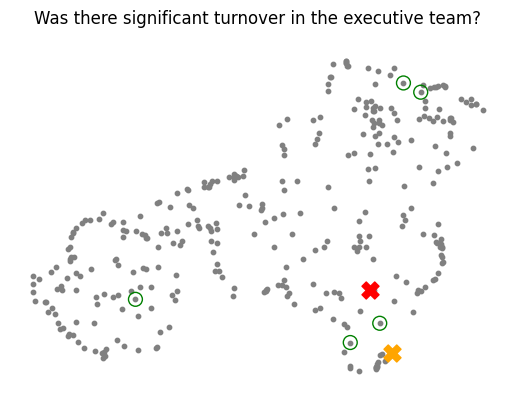

In [ ]:
plot_query_emb_new('Was there significant turnover in the executive team?')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

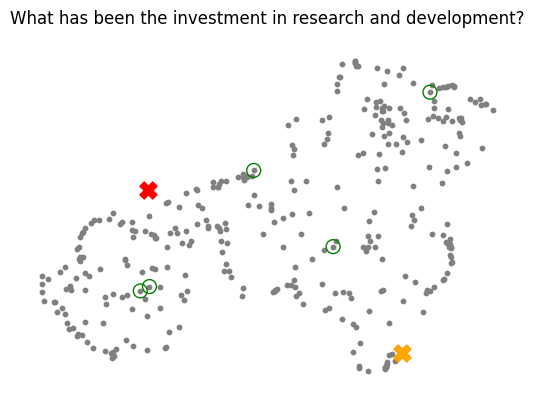

In [ ]:
plot_query_emb_new('What has been the investment in research and development?')

### **query --> LLM --> (Queries Generated by LLM + Original Queries) --> Retrived Details from VDB For All Queries --> LLM --> Final Answer**

In [ ]:
# def augment_multiple_query(query, model="gpt-3.5-turbo"):
#     messages = [
#         {
#             "role": "system",
#             "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
#             "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
#             "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
#             "Make sure they are complete questions, and that they are related to the original question."
#             "Output one question per line. Do not number the questions."
#         },
#         {"role": "user", "content": query}
#     ]

#     response = openai_client.chat.completions.create(
#         model=model,
#         messages=messages,
#     )
#     content = response.choices[0].message.content
#     content = content.split("\n")
#     return content

In [ ]:
###### Gemini by Author Ashis#######

'''You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
 "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
 "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
"Make sure they are complete questions, and that they are related to the original question."
"Output one question per line. Do not number the questions.'''

def augment_multiple_query(query):
  llm = ChatGoogleGenerativeAI(google_api_key=api_key, model = 'gemini-pro')
  prompt = f'''You are a helpful expert financial research assistant. Your users are asking questions about an annual report.
Suggest up to five additional related questions to help them find the information they need, for the provided question.
Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic.
Make sure they are complete questions, and that they are related to the original question.
Output one question per line. Do not number the questions.Question is:\n\n{query}\n\n Suggested Questions :\n'''
  response = llm.invoke(prompt)
  return response.content.split('\n')

In [ ]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

In [ ]:
augmented_queries = [ i.replace('-','').strip() for i in augmented_queries]

In [ ]:
augmented_queries

["How did the company's operations in different regions or segments contribute to the revenue growth?",
 'Were there any specific products or services that drove a significant portion of the revenue increase?',
 'Did the company implement any new strategies or initiatives that positively impacted revenue?',
 "How did the company's pricing strategy contribute to the revenue growth?",
 "Did favorable economic conditions or industry trends positively impact the company's revenue?"]

In [ ]:
import chromadb
from langchain.document_loaders import PyPDFLoader
doc = PyPDFLoader('/content/microsoft_annual_report_2022.pdf').load()

In [ ]:
doc

In [ ]:
doc_text = [i.page_content for i in doc]
doc_text = [i for i in doc_text if i]
len(doc_text)

92

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
split_object = RecursiveCharacterTextSplitter(chunk_size = 1000 , chunk_overlap=0,separators =['\n\n','\n','.',' ',''])
character_split_text = split_object.split_text('/n/n'.join(doc_text))

In [ ]:
len(character_split_text)

308

In [ ]:
character_split_text[0]

'/n/n1 Dear shareholders, colleagues, customers, and partners:  \nWe are living through a period of historic economic, societal, and geopolitical change. The world in 2022 looks nothing like \nthe world in 2019. As I write this, inflation is at a 40 -year high, supply chains are stretched, and the war in Ukraine is \nongoing. At the same time, we are entering a technological era with the potential to power awesome advancements \nacross every sector of our economy and society. As the world’s largest software company, this places us at a historic \nintersection of opportunity and responsibility to the world around us.  \nOur mission to empower every person and every organization on the planet to achieve more has never been more \nurgent or more necessary. For all the uncertainty in the world, one thing is clear: People and organizations in every \nindustry are increasingly looking to digital technology to overcome today’s challenges and emerge stronger. And no'

In [ ]:
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
token = SentenceTransformersTokenTextSplitter(chunk_overlap = 0, tokens_per_chunk=256)
token_text_split = []
for i in character_split_text:
  token_text_split += token.split_text(i)
# token_text_split = token.split_text('\n\n'.join([i for i in character_split_text]))


In [ ]:
token_text_split[0]

'/ n / n1 dear shareholders, colleagues, customers, and partners : we are living through a period of historic economic, societal, and geopolitical change. the world in 2022 looks nothing like the world in 2019. as i write this, inflation is at a 40 - year high, supply chains are stretched, and the war in ukraine is ongoing. at the same time, we are entering a technological era with the potential to power awesome advancements across every sector of our economy and society. as the world ’ s largest software company, this places us at a historic intersection of opportunity and responsibility to the world around us. our mission to empower every person and every organization on the planet to achieve more has never been more urgent or more necessary. for all the uncertainty in the world, one thing is clear : people and organizations in every industry are increasingly looking to digital technology to overcome today ’ s challenges and emerge stronger. and no'

In [ ]:
len(token_text_split)

312

In [ ]:
client = chromadb.Client()

In [ ]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
emb = SentenceTransformerEmbeddingFunction()
client.create_collection('my_collection',embedding_function=emb)


In [ ]:
ids = [str(i) for i in range(len(token_text_split))]
client.list_collections()

[Collection(name=my_collection)]

In [ ]:
my_collection = client.get_collection('my_collection')
my_collection.add(ids=ids , documents=token_text_split,embeddings=)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:01<00:00, 53.4MiB/s]


In [ ]:
my_collection.get(ids=[str(1)])

{'ids': ['1'],
 'embeddings': None,
 'metadatas': [None],
 'documents': ['company is better positioned to help them than microsoft. every day this past fiscal year i have had the privilege to witness our customers use our platforms and tools to connect what technology can do with what the world needs it to do. here are just a few examples : • ferrovial, which builds and manages some of the world ’ s busiest airports and highways, is using our cloud infrastructure to build safer roads as it prepares for a future of autonomous transportation. • peace parks foundation, a nonprofit helping protect natural ecosystems in southern africa, is using microsoft dynamics 365 and power bi to secure essential funding, as well as our azure ai and iot solutions to help rangers scale their park maintenance and wildlife crime prevention work. • one of the world ’ s largest robotics companies, kawasaki heavy industries, is using the breadth of our tools — from azure iot and hololens — to create an indust

In [ ]:
queries = [original_query] + augmented_queries
results = my_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
• research and development expenses increased $ 3. 8 billion or 18 %
driven by investments in cloud engineering, gaming, and linkedin. •
sales and marketing expenses increased $ 1. 7 billion or 8 % driven by
investments in commercial sales and linkedin. sales and marketing
included a favorable foreign currency impact of 2 %. • general and
administrative expenses increased $ 793 million or 16 % driven by
investments in corporate functions. operating income increased $ 13. 5
billion or 19 % driven by growth across each of our segments. current
year net income and diluted eps were positively impacted by the net tax
benefit related to the transfer of intangible properties, which
resulted in an increase to net income and diluted eps of $ 3. 3 billion
and $ 0. 44, respectively. prior year net income and diluted eps were
positively impacted by the net tax benefit related to the india supreme
court


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


  0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

(-6.439017200469971,
 3.5791300773620605,
 6.0915189504623415,
 11.601672101020814)

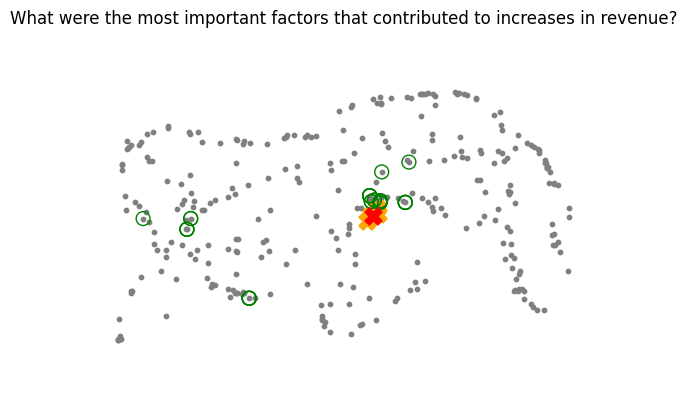

In [ ]:
original_query_embedding = emb([original_query])
augmented_query_embeddings = emb(augmented_queries)
embeddings = my_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

## **Cross-encoder re-ranking**
* **Bi - Encoder** : Takes two query passed separately to BERT and al last rank based on cosine similarity got for individual query

* **Cross - Encoder** : Pass both queries to BERT then to a classifier model to get a score how similar both are.


In [ ]:
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
query = 'What has been the investment in research and development?'
result  = my_collection.query(query_texts= query, n_results = 10 , include = ['documents','embeddings','distances'])

In [ ]:
retrived_docs = result['documents'][0]
retrived_docs

In [ ]:
pairs = [[query,doc] for doc in retrived_docs]

In [ ]:
scores = cross_encoder.predict(pairs)
scores

array([  1.9924389,  -1.9156878,  -9.154852 ,  -1.8504307,  -9.070967 ,
       -11.017633 , -10.758376 ,  -8.063997 ,  -7.6426487, -10.862867 ],
      dtype=float32)

In [ ]:
top_5_score_indices = np.argsort(scores)[::-1][:5]
top_5_score_indices


array([0, 3, 1, 8, 7])

In [ ]:
print(result['distances'])

In [ ]:
for i in range(len(result['ids'][0])):
  print(result['distances'][0][i])
  print('*'*30)
  print(result['documents'][0][i])


0.9951761960983276
******************************
believe offer significant opportunities to deliver value to our customers and growth for the company. based on our assessment of key technology trends, we maintain our long - term commitment to research and development across a wide spectrum of technologies, tools, and platforms spanning digital work and life experiences, cloud computing, ai, devices, and operating systems. while our main product research and development facilities are located in redmond, washington, we also operate research and development facilities in other parts of the u. s. and around the world. this global approach helps us remain competitive in local markets and enables us to continue to attract top talent from across the world. we plan to continue to make significant investments in a broad range of product research and development activities, and as appropriate we will coordinate our research and development across operating segments and leverage the results acr

In [ ]:
[pairs[i] for i in top_5_score_indices]

[['What has been the investment in research and development?',
  'believe offer significant opportunities to deliver value to our customers and growth for the company. based on our assessment of key technology trends, we maintain our long - term commitment to research and development across a wide spectrum of technologies, tools, and platforms spanning digital work and life experiences, cloud computing, ai, devices, and operating systems. while our main product research and development facilities are located in redmond, washington, we also operate research and development facilities in other parts of the u. s. and around the world. this global approach helps us remain competitive in local markets and enables us to continue to attract top talent from across the world. we plan to continue to make significant investments in a broad range of product research and development activities, and as appropriate we will coordinate our research and development across operating segments and leverage

### **Re-ranking with Query Expansion**

In [ ]:
original_query

'What were the most important factors that contributed to increases in revenue?'

In [ ]:
augmented_queries

["How did the company's operations in different regions or segments contribute to the revenue growth?",
 'Were there any specific products or services that drove a significant portion of the revenue increase?',
 'Did the company implement any new strategies or initiatives that positively impacted revenue?',
 "How did the company's pricing strategy contribute to the revenue growth?",
 "Did favorable economic conditions or industry trends positively impact the company's revenue?"]

In [ ]:
queries = [original_query] + augmented_queries
queries

['What were the most important factors that contributed to increases in revenue?',
 "How did the company's operations in different regions or segments contribute to the revenue growth?",
 'Were there any specific products or services that drove a significant portion of the revenue increase?',
 'Did the company implement any new strategies or initiatives that positively impacted revenue?',
 "How did the company's pricing strategy contribute to the revenue growth?",
 "Did favorable economic conditions or industry trends positively impact the company's revenue?"]

In [ ]:
results = my_collection.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
retrieved_documents = results['documents']
retrieved_documents[0]

In [ ]:
# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
  for document in documents:
    unique_documents.add(document)

unique_documents = list(unique_documents)


In [ ]:
len(unique_documents) # because one answer or text can be common in multiple queries , so this is unique relevant text

20

In [ ]:
pairs = []
for doc in unique_documents:
    pairs.append([original_query, doc])

In [ ]:
scores = cross_encoder.predict(pairs)


In [ ]:
scores

array([ -4.693813 ,  -8.289019 , -10.540943 ,  -5.6362386,  -4.608513 ,
        -7.4164104,  -5.0521755, -10.915653 ,  -8.90671  ,  -4.8808355,
        -5.172134 ,  -7.0028257, -10.190271 ,  -8.788288 ,  -9.798315 ,
        -2.8309708,  -3.9877326,  -4.23954  , -11.091296 ,  -6.9675364],
      dtype=float32)

In [ ]:
top_5_context = np.argsort(scores)[::-1][:5]
top_5_context

array([15, 16, 17,  4,  0])

In [ ]:
[pairs[i] for i in top_5_context]

[['What were the most important factors that contributed to increases in revenue?',
  'commercial. windows oem revenue increased 11 % driven by continued strength in the commercial pc market, which has higher revenue per license. windows commercial products and cloud services revenue increased 11 % driven by demand for microsoft 365. / n / n36 • search and news advertising revenue increased $ 2. 3 billion or 25 %. search and news advertising revenue excluding traffic acquisition costs increased 27 % driven by higher revenue per search and search volume. • gaming revenue increased $ 860 million or 6 % on a strong prior year comparable that benefited from xbox series x | s launches and stay - at - home scenarios, driven by growth in xbox hardware and xbox content and services. xbox hardware revenue increased 16 % due to continued demand for xbox series x | s. xbox content and services revenue increased 3 % driven by growth in xbox game pass subscriptions and first - party content, offset